In [7]:
#!pip install fastbook

##### A. Single Label Classification

In [4]:
from fastai.vision.all import *

In [5]:
path = untar_data(URLs.PETS)

In [6]:
path.ls()

(#2) [Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/annotations')]

In [8]:
files = get_image_files(path/"images")
len(files)

7390

In [9]:
def label_func(f): return f[0].isupper()

##### a - image loader approach

In [17]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

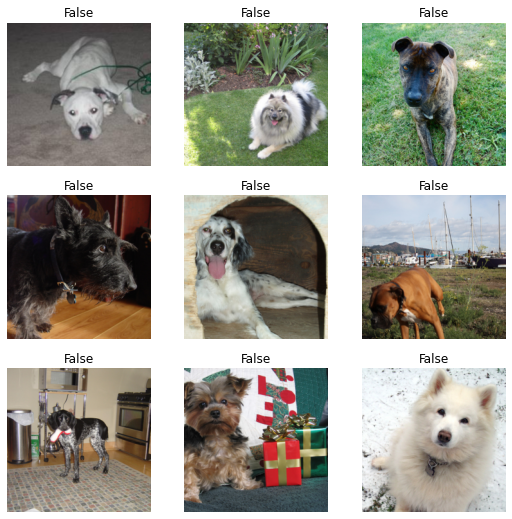

In [18]:
dls.show_batch()


In [19]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

In [20]:
learn.predict(files[0])

('True', TensorBase(1), TensorBase([2.3427e-04, 9.9977e-01]))

##### b. regex to find label approach

In [23]:
import re

In [24]:
pat = r'^(.*)_\d+.jpg'

In [62]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

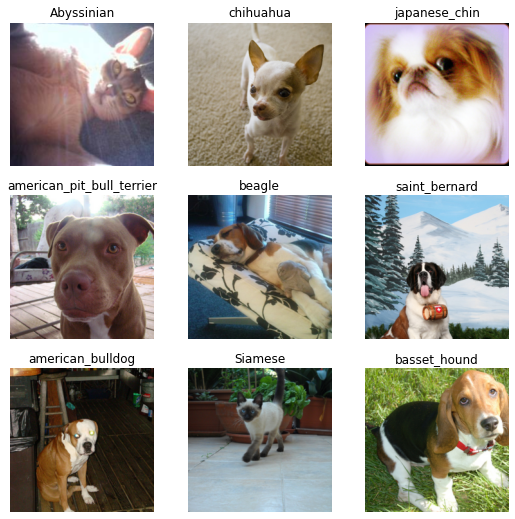

In [63]:
dls.show_batch()

In [64]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

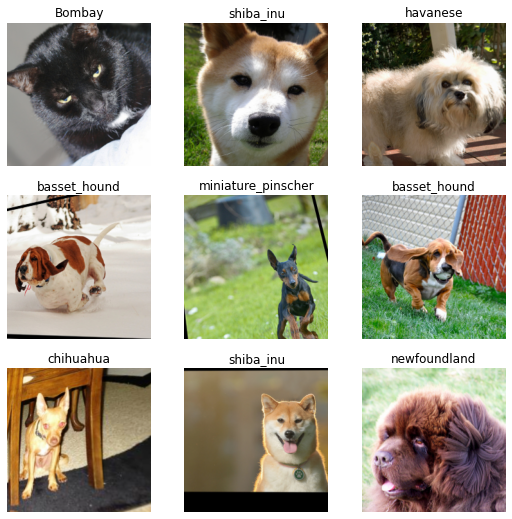

In [65]:
dls.show_batch()

In [66]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

##### -- useful learning rate finder

SuggestedLRs(valley=0.0008317637839354575)

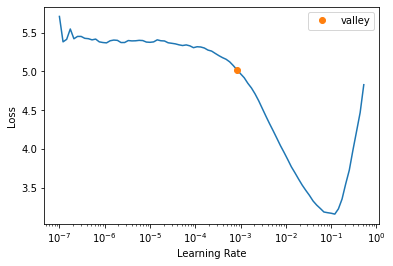

In [67]:
learn.lr_find()

In [73]:
learn.fine_tune(3, 8e-4)

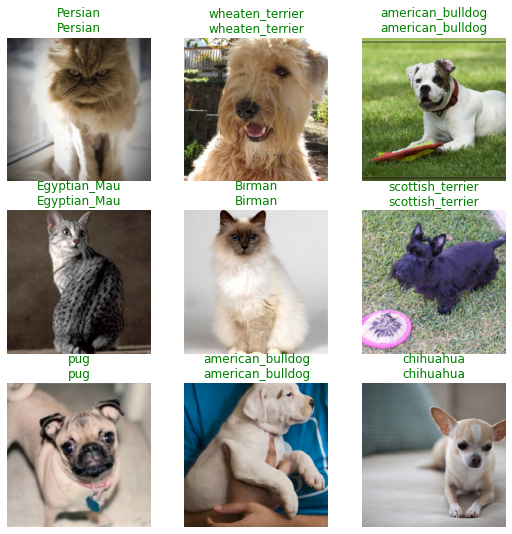

In [69]:
learn.show_results()

In [45]:
interp = Interpretation.from_learner(learn)

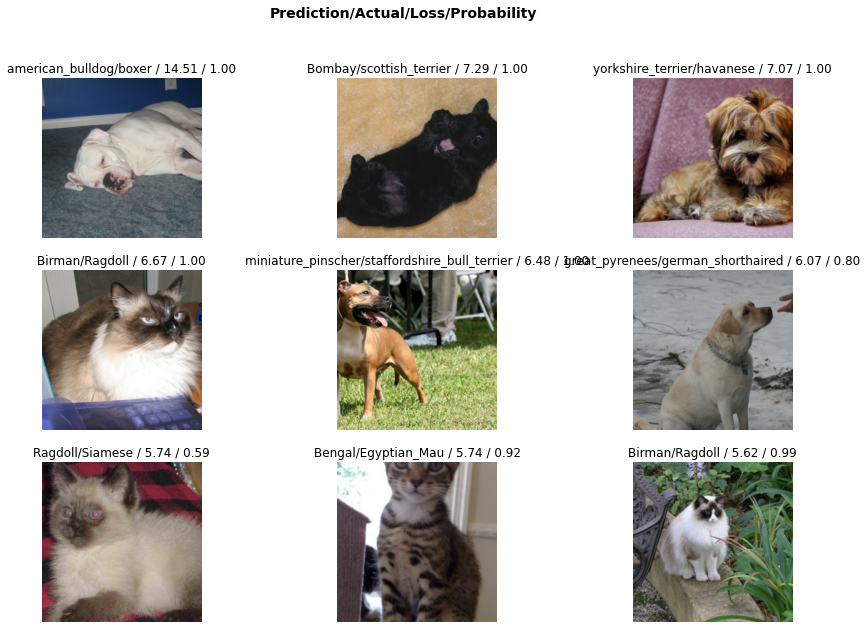

In [46]:
interp.plot_top_losses(9, figsize=(15,10))

##### Datablock approach

In [47]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

In [48]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")

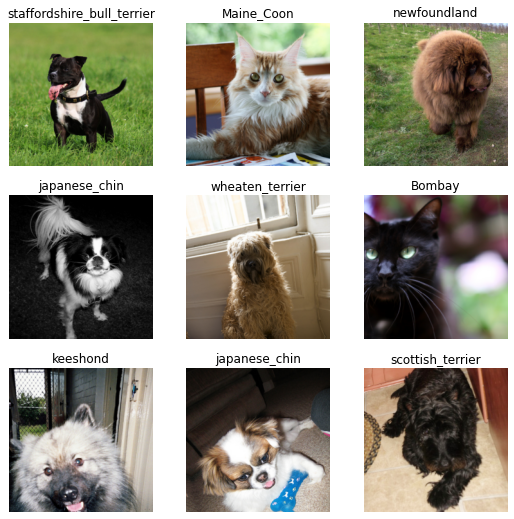

In [49]:
dls.show_batch(max_n=9)


In [50]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

In [74]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

In [75]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")

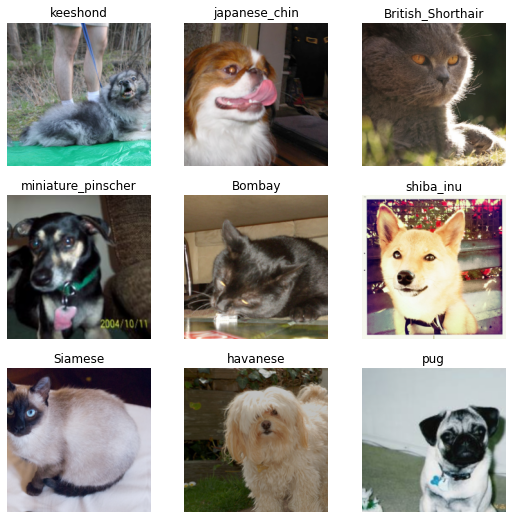

In [76]:
dls.show_batch(max_n=9)

In [77]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(valley=0.0006918309954926372)

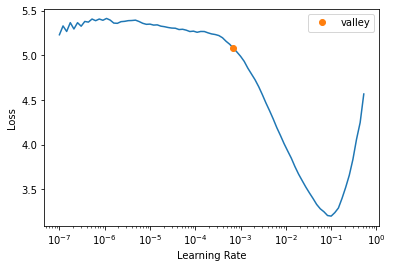

In [78]:
learn.lr_find()

In [79]:
learn.fine_tune(5, 7e-4)

# B. Multi-label classification

In [80]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/home/ec2-user/.fastai/data/pascal_2007/valid.json'),Path('/home/ec2-user/.fastai/data/pascal_2007/test.json'),Path('/home/ec2-user/.fastai/data/pascal_2007/test'),Path('/home/ec2-user/.fastai/data/pascal_2007/train.json'),Path('/home/ec2-user/.fastai/data/pascal_2007/test.csv'),Path('/home/ec2-user/.fastai/data/pascal_2007/segmentation'),Path('/home/ec2-user/.fastai/data/pascal_2007/train.csv'),Path('/home/ec2-user/.fastai/data/pascal_2007/train')]

In [81]:
df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

In [82]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

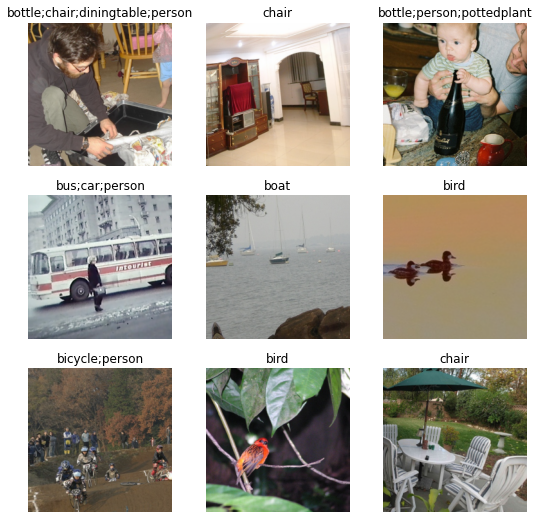

In [83]:
dls.show_batch()

In [84]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0014454397605732083)

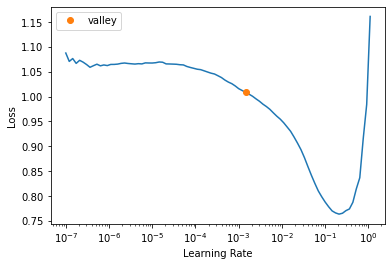

In [85]:
learn.lr_find()

In [88]:
learn.fine_tune(3, 1e-3)

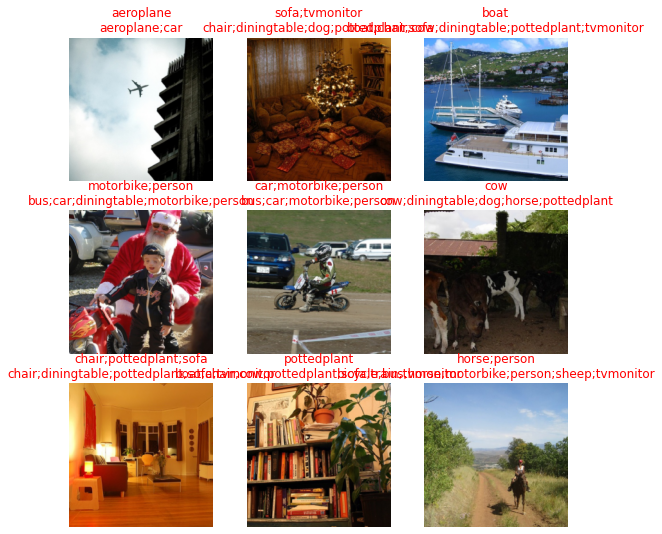

In [89]:
learn.show_results()

In [90]:
learn.predict(path/'train/000005.jpg')

((#7) ['bottle','bus','chair','diningtable','pottedplant','sofa','tvmonitor'],
 TensorBase([False, False, False, False,  True,  True, False, False,  True, False,
          True, False, False, False, False,  True, False,  True, False,  True]),
 TensorBase([0.0940, 0.1782, 0.1707, 0.4082, 0.5333, 0.5186, 0.0427, 0.1210, 0.9999,
         0.2461, 0.9846, 0.0448, 0.4667, 0.3076, 0.0566, 0.6461, 0.3214, 0.8487,
         0.1997, 0.7684]))

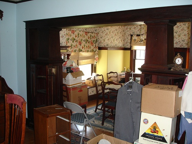

In [91]:
img = PILImage.create(path/'train/000005.jpg')
img.to_thumb(192)

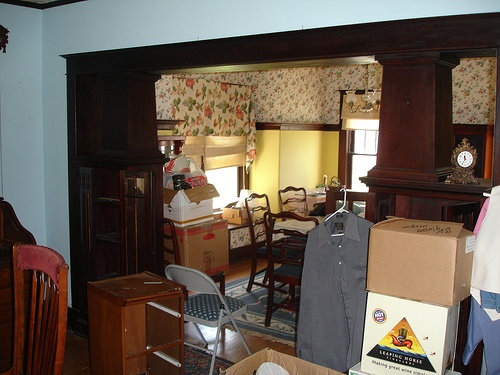

In [92]:
img

In [93]:
interp = Interpretation.from_learner(learn)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


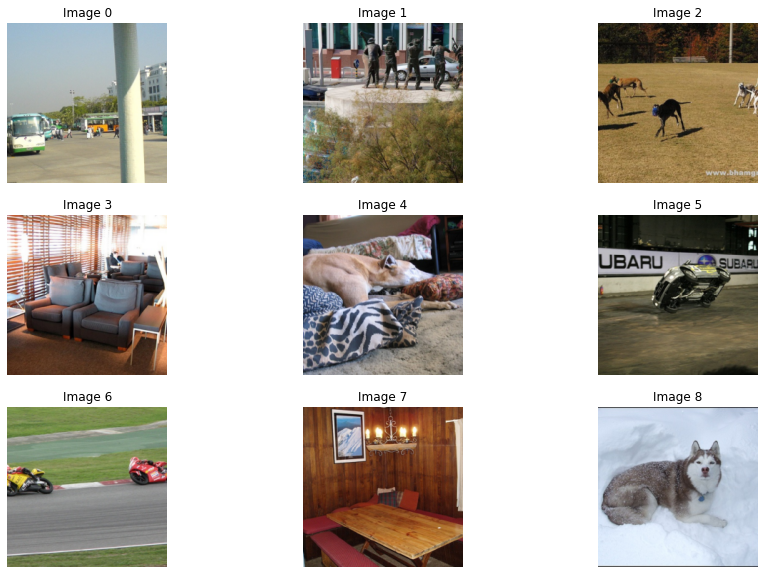

In [94]:
interp.plot_top_losses(9, figsize=(15,10))

In [98]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))

In [99]:
dls = pascal.dataloaders(df)

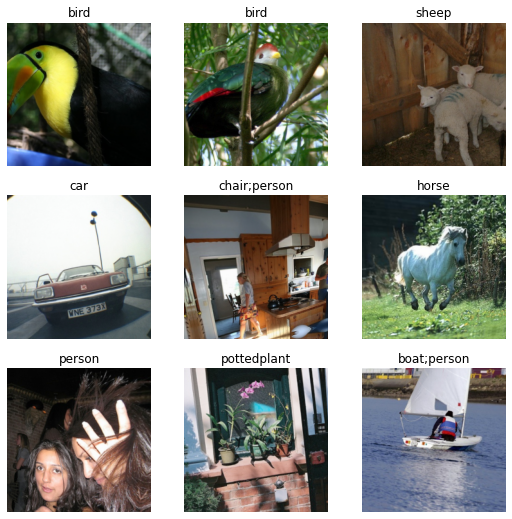

In [100]:
dls.show_batch(max_n=9)

## Segmentation

In [101]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/home/ec2-user/.fastai/data/camvid_tiny/images'),Path('/home/ec2-user/.fastai/data/camvid_tiny/codes.txt'),Path('/home/ec2-user/.fastai/data/camvid_tiny/labels')]

In [102]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [103]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/home/ec2-user/.fastai/data/camvid_tiny/images/0016E5_08370.png')

In [104]:
(path/"labels").ls()[0]

Path('/home/ec2-user/.fastai/data/camvid_tiny/labels/Seq05VD_f02880_P.png')

In [105]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [106]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


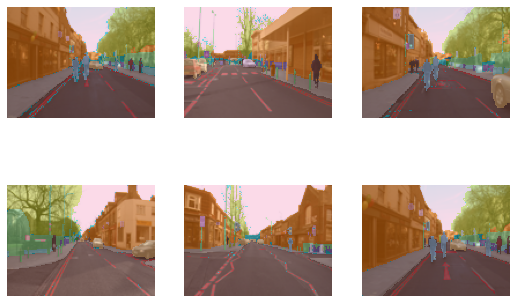

In [107]:
dls.show_batch(max_n=6)

In [108]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)

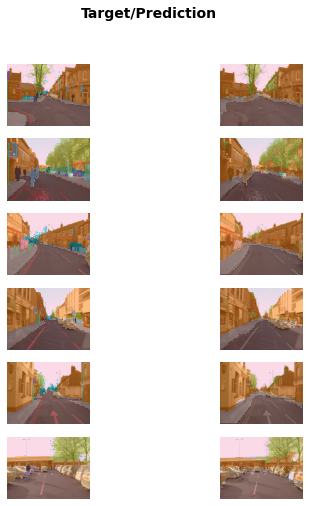

In [109]:
learn.show_results(max_n=6, figsize=(7,8))

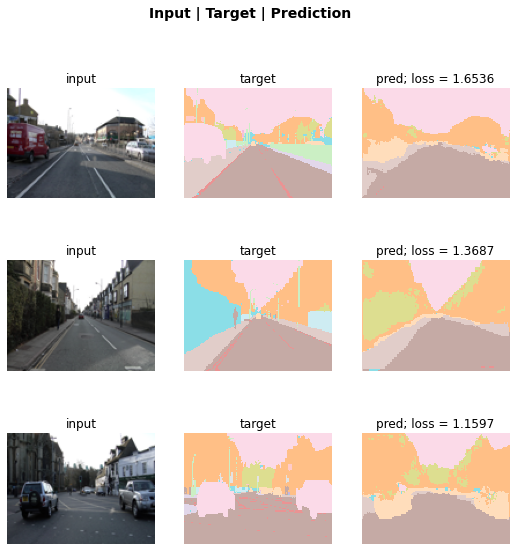

In [110]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

In [111]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [112]:
dls = camvid.dataloaders(path/"images", path=path, bs=8)

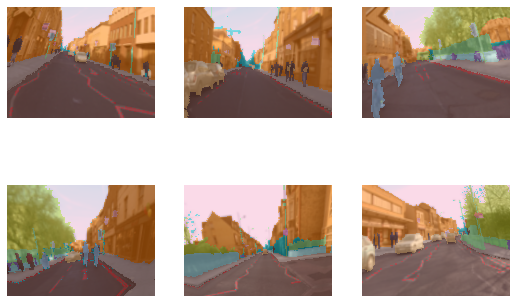

In [113]:
dls.show_batch(max_n=6)

# Head detection

In [114]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [115]:
path.ls()

(#50) [Path('/home/ec2-user/.fastai/data/biwi_head_pose/io_sample.cpp'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/06'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/16.obj'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01.obj'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/11.obj'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/04.obj'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/14.obj'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/20'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/23'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/24.obj')...]

In [116]:
(path/'01').ls()

(#1000) [Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00375_rgb.jpg'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00145_pose.txt'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00491_pose.txt'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00030_pose.txt'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00113_rgb.jpg'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00379_rgb.jpg'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00227_rgb.jpg'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00054_rgb.jpg'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00443_pose.txt'),Path('/home/ec2-user/.fastai/data/biwi_head_pose/01/frame_00031_pose.txt')...]

In [117]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/home/ec2-user/.fastai/data/biwi_head_pose/06/frame_00113_pose.txt')

In [118]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

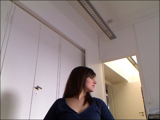

In [119]:
im.to_thumb(160)

In [120]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [121]:
get_ctr(img_files[0])

tensor([379.1756, 318.0512])

In [122]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

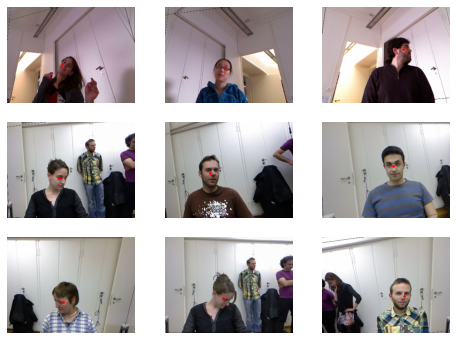

In [123]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [124]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.001737800776027143)

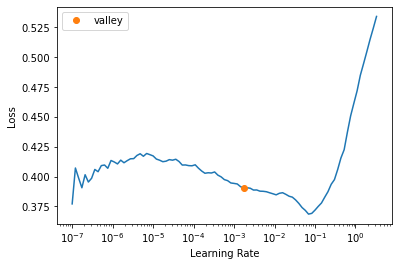

In [125]:
learn.lr_find()

In [126]:
learn.fine_tune(1, 5e-3)

In [ ]:
learn.fine_tune(1, 5e-3)